# History Matching Error Analysis: Visualization & Diagnostics
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Reservoir Simulation & History Matching

This notebook demonstrates how to diagnose the quality of a reservoir simulation history match. We will visualize the mismatch between **Observed** (field data) and **Simulated** (model output) data for Reservoir Pressure and Oil Rate.

### Objectives
1. Load and Preprocess History Matching data.
2. Calculate Residuals and Relative Errors.
3. Visualize mismatch using Line plots, Residual plots, and Cross-plots.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Visualization Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data
We will load the `data_hm.csv` containing the time-series data.

In [2]:
# Load dataset
df = pd.read_csv('data_hm.csv')

# Convert Date column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Inspect the first few rows
df.head()

,Date,Observed_Pressure,Simulated_Pressure,Observed_OilRate,Simulated_OilRate
0,2020-01-01,4500,4510,2000,2050
1,2020-02-01,4480,4490,1980,1990
2,2020-03-01,4450,4475,1950,1980
3,2020-04-01,4420,4460,1900,1970
4,2020-05-01,4390,4440,1850,1950


## 2. Calculate Error Metrics
We need to calculate the residuals to quantify the mismatch.

The **Residual** is the absolute difference:
$$Residual = Sim - Obs$$

The **Relative Error (%)** helps us understand the magnitude relative to the observed value:
$$\% Error = \frac{Sim - Obs}{Obs} \times 100$$

In [3]:
# Calculate Pressure Residuals
df['Pres_Residual'] = df['Simulated_Pressure'] - df['Observed_Pressure']
df['Pres_Error_Pct'] = (df['Pres_Residual'] / df['Observed_Pressure']) * 100

# Calculate Oil Rate Residuals
df['Oil_Residual'] = df['Simulated_OilRate'] - df['Observed_OilRate']
df['Oil_Error_Pct'] = (df['Oil_Residual'] / df['Observed_OilRate']) * 100

# Display calculated metrics
df[['Date', 'Pres_Residual', 'Pres_Error_Pct', 'Oil_Residual', 'Oil_Error_Pct']].head()

,Date,Pres_Residual,Pres_Error_Pct,Oil_Residual,Oil_Error_Pct
0,2020-01-01,10,0.222222,50,2.500000
1,2020-02-01,10,0.223214,10,0.505051
2,2020-03-01,25,0.561798,30,1.538462
3,2020-04-01,40,0.904977,70,3.684211
4,2020-05-01,50,1.138952,100,5.405405


## 3. Visualization: History Match Overview (Time-Series)
The most fundamental plot in history matching is the time-series overlay. We look for the "gap" between the solid line (Simulation) and the points/dots (Observation).

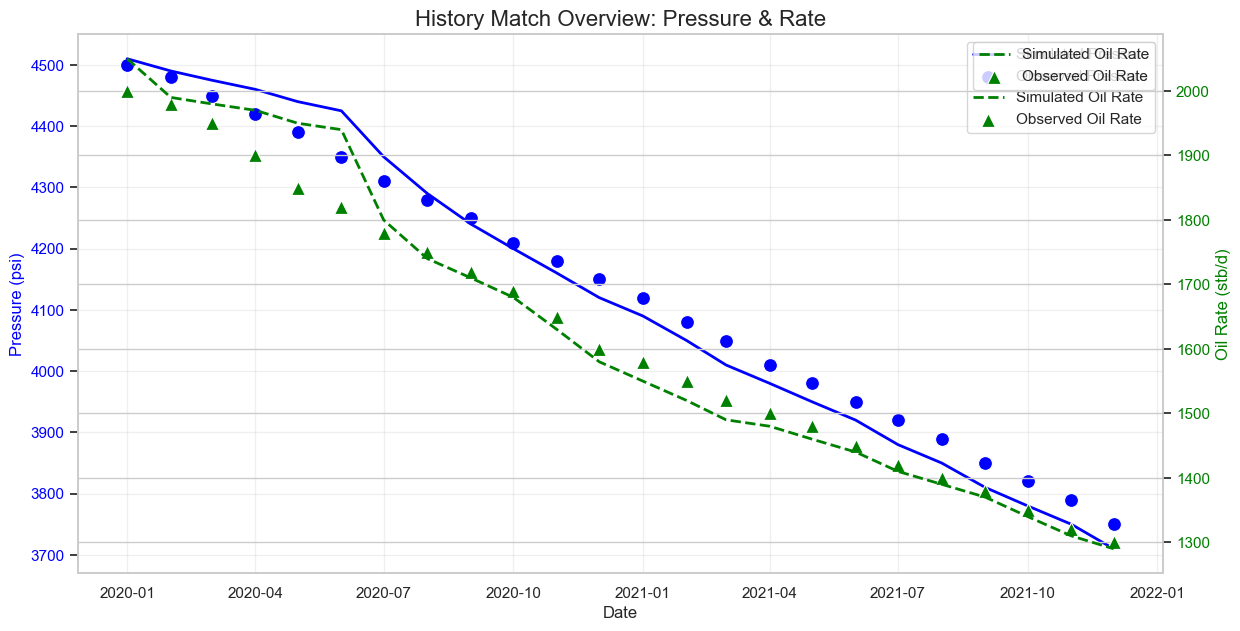

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Pressure (Left Axis)
sns.lineplot(data=df, x='Date', y='Simulated_Pressure', label='Simulated Pressure', color='blue', ax=ax1, linewidth=2)
sns.scatterplot(data=df, x='Date', y='Observed_Pressure', label='Observed Pressure', color='blue', ax=ax1, marker='o', s=100)
ax1.set_ylabel('Pressure (psi)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for Oil Rate
ax2 = ax1.twinx()
sns.lineplot(data=df, x='Date', y='Simulated_OilRate', label='Simulated Oil Rate', color='green', ax=ax2, linewidth=2, linestyle='--')
sns.scatterplot(data=df, x='Date', y='Observed_OilRate', label='Observed Oil Rate', color='green', ax=ax2, marker='^', s=100)
ax2.set_ylabel('Oil Rate (stb/d)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Title and Legend
plt.title('History Match Overview: Pressure & Rate', fontsize=16)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax1.grid(True, alpha=0.3)

plt.show()

## 4. Visualization: Residual Analysis (Identifying Mismatch Regions)
While the plot above shows the trend, it is hard to quantify the exact deviation. A **Residual Plot** isolates the error.

* **Positive Residual**: Simulation > Observation (Overestimation)
* **Negative Residual**: Simulation < Observation (Underestimation)
* **Zero Line**: Perfect Match

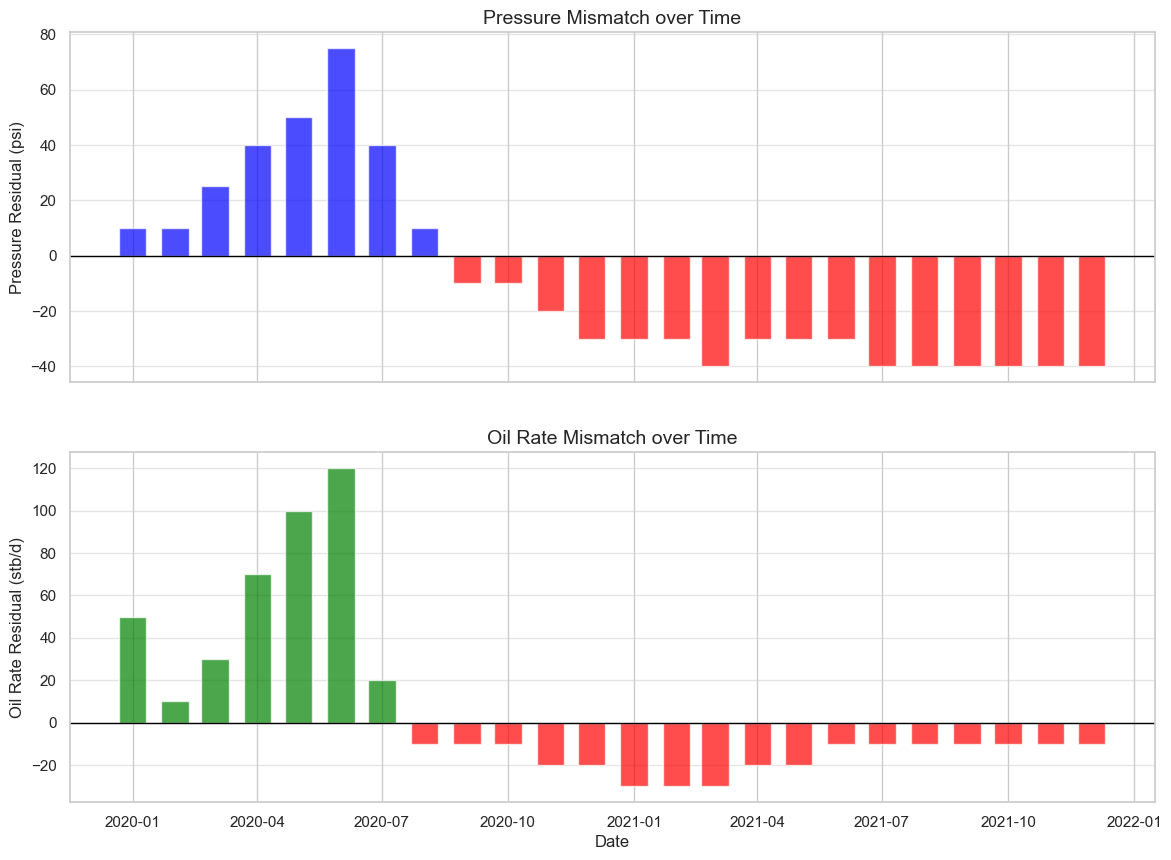

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Pressure Residuals
colors_pres = ['red' if x < 0 else 'blue' for x in df['Pres_Residual']]
ax1.bar(df['Date'], df['Pres_Residual'], color=colors_pres, width=20, alpha=0.7)
ax1.axhline(0, color='black', linewidth=1)
ax1.set_ylabel('Pressure Residual (psi)')
ax1.set_title('Pressure Mismatch over Time', fontsize=14)
ax1.grid(axis='y', alpha=0.5)

# Oil Rate Residuals
colors_oil = ['red' if x < 0 else 'green' for x in df['Oil_Residual']]
ax2.bar(df['Date'], df['Oil_Residual'], color=colors_oil, width=20, alpha=0.7)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_ylabel('Oil Rate Residual (stb/d)')
ax2.set_title('Oil Rate Mismatch over Time', fontsize=14)
ax2.grid(axis='y', alpha=0.5)

plt.xlabel('Date')
plt.show()

## 5. Visualization: Cross-Plots (Goodness of Fit)
A Cross-Plot compares Observed (X-axis) vs Simulated (Y-axis).
* **Perfect Match**: All points lie on the 45-degree ($y=x$) line.
* **Scatter**: Indicates the variance of the error.
* **Bias**: If points are consistently above or below the line.

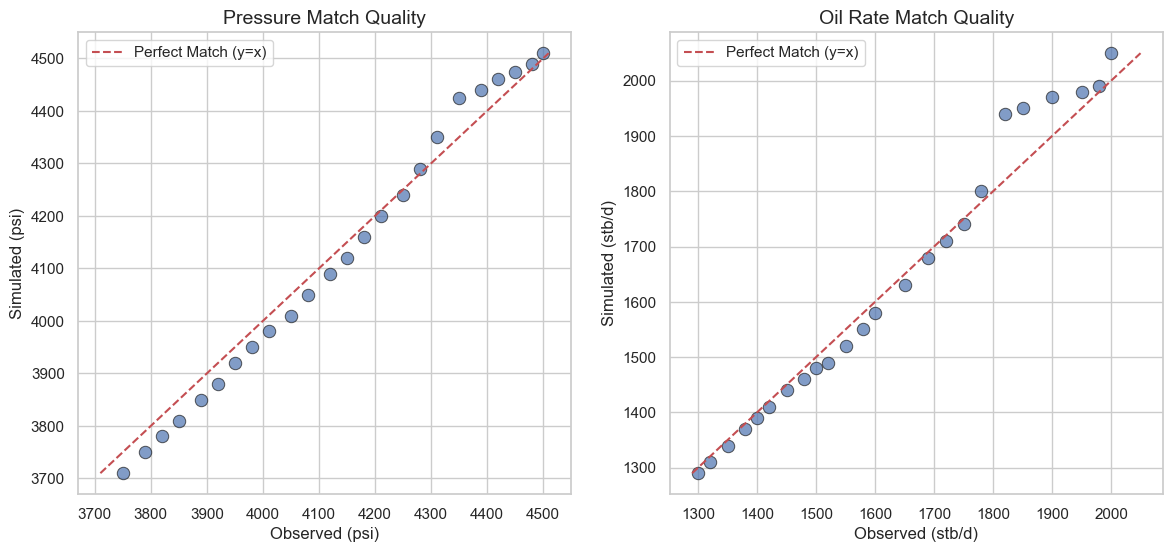

In [6]:
def plot_crossplot(ax, obs, sim, title, unit):
    # Scatter plot
    sns.scatterplot(x=obs, y=sim, ax=ax, s=80, alpha=0.7, edgecolor='k')
    
    # 45-degree line (Perfect Match)
    min_val = min(obs.min(), sim.min())
    max_val = max(obs.max(), sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Match (y=x)')
    
    # Styling
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(f'Observed {unit}')
    ax.set_ylabel(f'Simulated {unit}')
    ax.legend()
    ax.grid(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

plot_crossplot(ax1, df['Observed_Pressure'], df['Simulated_Pressure'], 'Pressure Match Quality', '(psi)')
plot_crossplot(ax2, df['Observed_OilRate'], df['Simulated_OilRate'], 'Oil Rate Match Quality', '(stb/d)')

plt.show()

## 6. Visualization: Distribution of Errors
Finally, we check the distribution of percentage errors. This tells us if our model is **biased** (e.g., median error is not 0) or has **high variance** (wide spread).

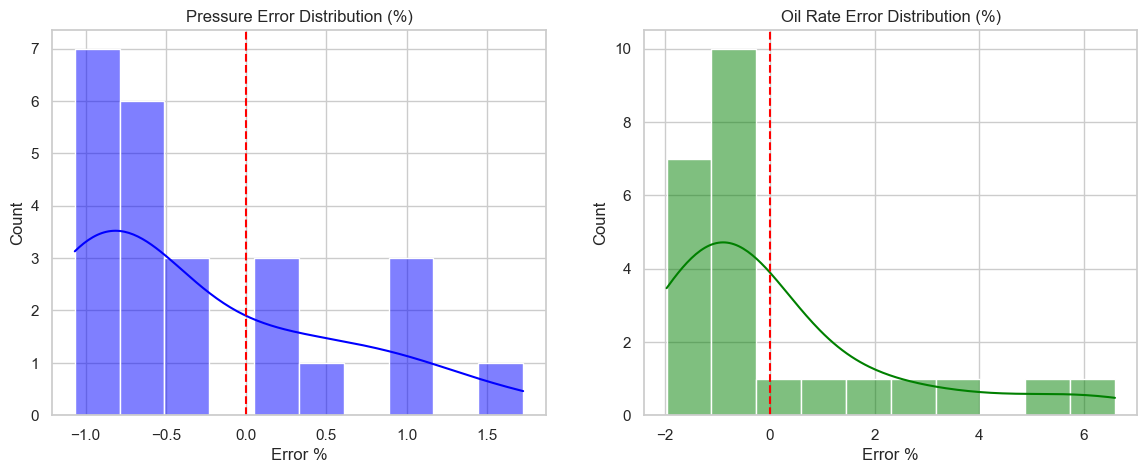

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pressure Error Distribution
sns.histplot(df['Pres_Error_Pct'], kde=True, ax=ax1, color='blue', bins=10)
ax1.axvline(0, color='red', linestyle='--', label='Zero Error')
ax1.set_title('Pressure Error Distribution (%)')
ax1.set_xlabel('Error %')

# Oil Rate Error Distribution
sns.histplot(df['Oil_Error_Pct'], kde=True, ax=ax2, color='green', bins=10)
ax2.axvline(0, color='red', linestyle='--', label='Zero Error')
ax2.set_title('Oil Rate Error Distribution (%)')
ax2.set_xlabel('Error %')

plt.show()

## 7. Quantitative Metrics (The Scorecard)
To objectively grade the quality of the history match, we calculate standard regression metrics.

* **RMSE (Root Mean Square Error)**: Represents the standard deviation of the residuals. Lower is better.
* **NRMSE (Normalized RMSE)**: RMSE divided by the range of data. Useful for comparing variables with different units (e.g., Pressure vs. Rate).
* **R² Score**: How well the simulated trend replicates the observed variance. (1.0 is perfect).

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def calculate_metrics(obs, sim, variable_name):
    rmse = np.sqrt(mean_squared_error(obs, sim))
    r2 = r2_score(obs, sim)
    
    # Normalized RMSE (RMSE / Range of Observation)
    nrmse = rmse / (obs.max() - obs.min())
    
    print(f"--- {variable_name} Performance ---")
    print(f"RMSE:  {rmse:.2f}")
    print(f"NRMSE: {nrmse:.4f} ({(nrmse*100):.2f}%)")
    print(f"R²:    {r2:.4f}")
    print("-" * 30)

calculate_metrics(df['Observed_Pressure'], df['Simulated_Pressure'], "Reservoir Pressure")
calculate_metrics(df['Observed_OilRate'], df['Simulated_OilRate'], "Oil Production Rate")

--- Reservoir Pressure Performance ---
RMSE:  35.03
NRMSE: 0.0467 (4.67%)
R²:    0.9765
------------------------------
--- Oil Production Rate Performance ---
RMSE:  40.05
NRMSE: 0.0572 (5.72%)
R²:    0.9651
------------------------------


## 8. Cumulative Production Analysis
Matching instantaneous rates is important for well deliverables, but matching **Cumulative Production** is critical for **Material Balance**.

If the Cumulative Oil Simulation deviates significantly from Observation, it indicates the model has incorrect Volume in Place (STOIIP) or Drive Mechanism energy.

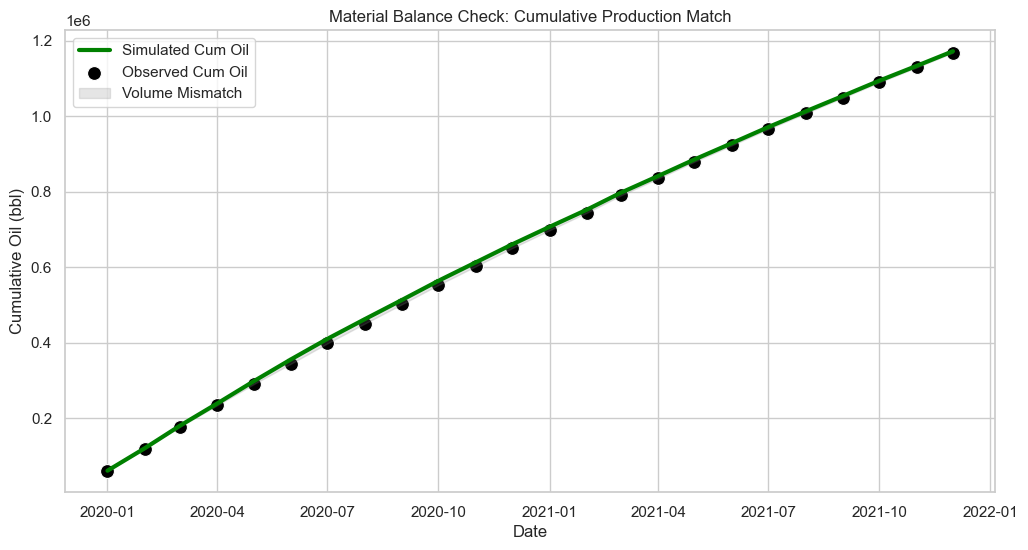

In [9]:
# Calculate Cumulative Production (Approximation: Rate * 30 days)
# Note: In real scenarios, use actual days in month. Here we assume monthly avg.
df['Cum_Obs_Oil'] = df['Observed_OilRate'].cumsum() * 30
df['Cum_Sim_Oil'] = df['Simulated_OilRate'].cumsum() * 30

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Cum_Sim_Oil', label='Simulated Cum Oil', color='green', linewidth=3)
sns.scatterplot(data=df, x='Date', y='Cum_Obs_Oil', label='Observed Cum Oil', color='black', s=100)
plt.fill_between(df['Date'], df['Cum_Sim_Oil'], df['Cum_Obs_Oil'], color='gray', alpha=0.2, label='Volume Mismatch')

plt.ylabel('Cumulative Oil (bbl)')
plt.title('Material Balance Check: Cumulative Production Match')
plt.legend()
plt.show()

## 9. Rolling Window Accuracy
Global metrics average out errors. To detect **when** the model physically diverges (e.g., onset of water breakthrough or changing boundary conditions), we use a **Rolling Correlation** or **Rolling RMSE**.

If the correlation drops suddenly, investigate the geological events at that specific date.

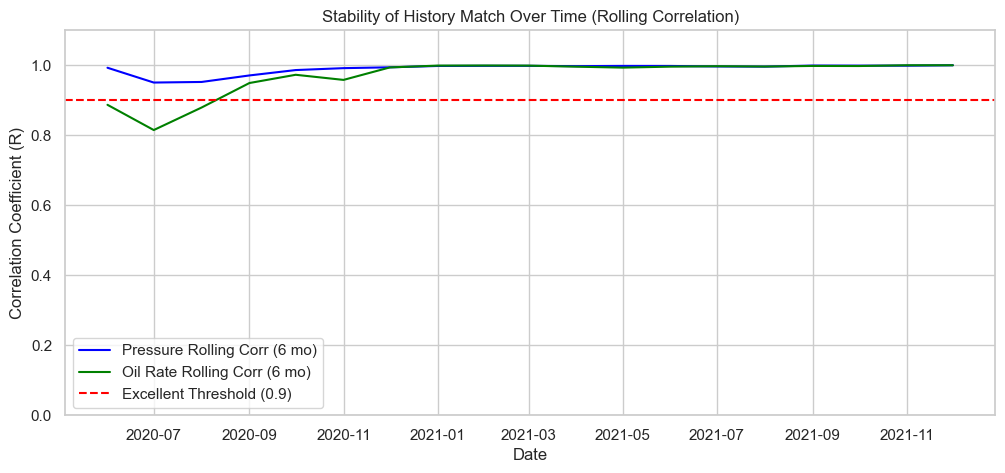

In [10]:
# Calculate Rolling Correlation (Window = 6 months)
window_size = 6
df['Rolling_Corr_Pressure'] = df['Observed_Pressure'].rolling(window=window_size).corr(df['Simulated_Pressure'])
df['Rolling_Corr_Oil'] = df['Observed_OilRate'].rolling(window=window_size).corr(df['Simulated_OilRate'])

# Plotting the degradation of match quality over time
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df, x='Date', y='Rolling_Corr_Pressure', label=f'Pressure Rolling Corr ({window_size} mo)', color='blue')
sns.lineplot(data=df, x='Date', y='Rolling_Corr_Oil', label=f'Oil Rate Rolling Corr ({window_size} mo)', color='green')

plt.axhline(0.9, color='red', linestyle='--', label='Excellent Threshold (0.9)')
plt.ylim(0, 1.1)
plt.ylabel('Correlation Coefficient (R)')
plt.title('Stability of History Match Over Time (Rolling Correlation)')
plt.legend()
plt.show()

## 10. Automated Diagnostic Report
Finally, we automate the interpretation. Based on the calculated errors, we tag specific time periods with a "Quality Flag."

* **Green**: Error < 5% (Good Match)
* **Yellow**: Error 5-15% (Acceptable)
* **Red**: Error > 15% (Poor Match - Needs Review)

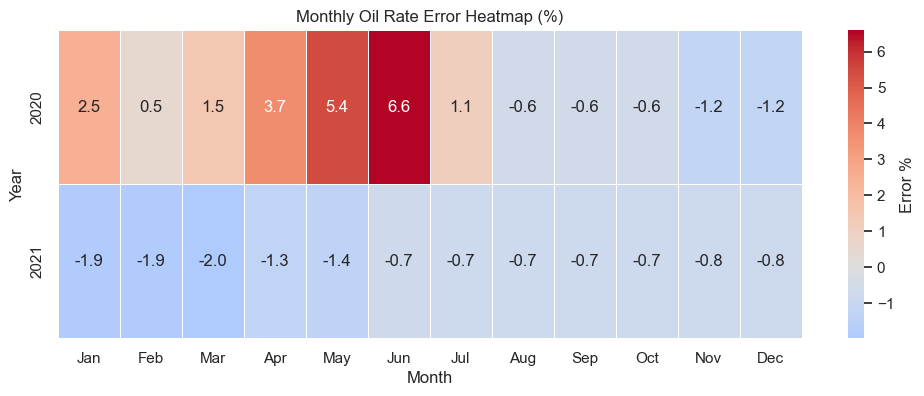

Good news: No months exceeded the 15% error threshold.


In [12]:
## 10. Automated Diagnostic Report (Corrected)
# Create helper columns for better heatmap plotting
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.strftime('%b') # Jan, Feb, Mar...

# Define thresholds for the traffic light system
def classify_match(error_pct):
    if abs(error_pct) <= 5:
        return 'Good'
    elif abs(error_pct) <= 15:
        return 'Fair'
    else:
        return 'Poor'

df['Match_Quality'] = df['Oil_Error_Pct'].apply(classify_match)

# Create the pivot table: Rows = Year, Columns = Month
heatmap_data = df.pivot_table(index='Year', columns='Month', values='Oil_Error_Pct')

# Reorder columns to ensure correct chronological order (Jan -> Dec)
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data = heatmap_data[months_order]

# Visualize
plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=True, fmt=".1f", 
            linewidths=.5, cbar_kws={'label': 'Error %'})
plt.title('Monthly Oil Rate Error Heatmap (%)')
plt.show()

# Print specific months to investigate
poor_matches = df[df['Match_Quality'] == 'Poor']
if not poor_matches.empty:
    print("WARNING: The following months require geological review (Error > 15%):")
    # Clean up the output to be readable
    print(poor_matches[['Date', 'Observed_OilRate', 'Simulated_OilRate', 'Oil_Error_Pct']].to_string(index=False))
else:
    print("Good news: No months exceeded the 15% error threshold.")

## 11. Error Decomposition: Bias vs. Variance
We decompose the error to understand the **nature** of the mismatch.

$$MSE = Bias^2 + Variance$$

* **Bias**: The average error (Are we consistently over/underestimating?).
* **Standard Deviation (SD) of Error**: The spread (How "noisy" or unstable is the match?).

We visualize this using a **Bullseye Plot**. The center (0,0) is a perfect match.

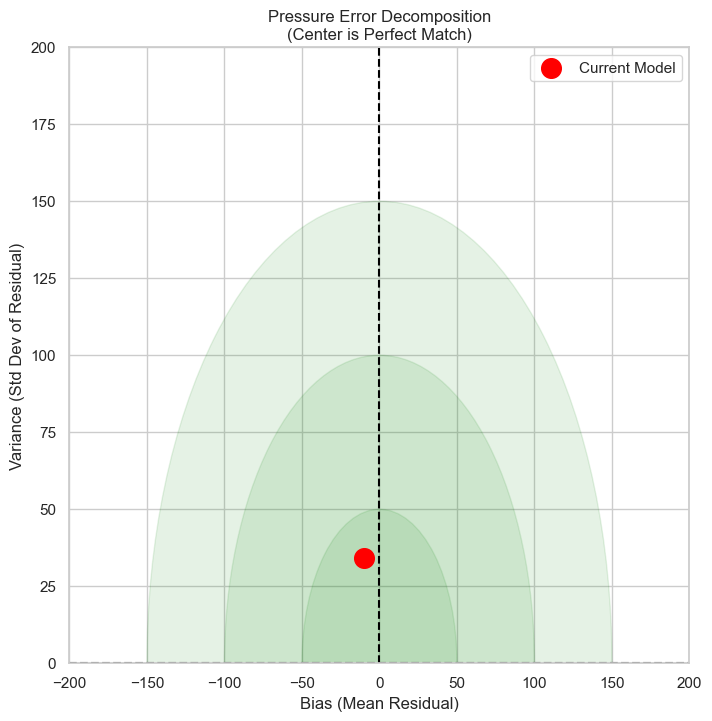

--- Pressure Error Decomposition Diagnostics ---
Bias (Systematic Error): -10.00
Spread (Random Noise):   34.29
>> ADVICE: High Variance detected. Check local heterogeneities or noise in observed data.


In [13]:
def plot_bullseye(df, residual_col, title):
    mean_error = df[residual_col].mean()
    std_error = df[residual_col].std()
    
    plt.figure(figsize=(8, 8))
    
    # Plot the specific match point
    plt.scatter(mean_error, std_error, color='red', s=200, label='Current Model', zorder=5)
    
    # Draw "Target" rings
    circles = [50, 100, 150] # Arbitrary units for "Good", "Fair", "Poor" zones
    for r in circles:
        circle = plt.Circle((0, 0), r, color='green', alpha=0.1)
        plt.gca().add_patch(circle)
        
    plt.axvline(0, color='black', linestyle='--')
    plt.axhline(0, color='black', linestyle='--')
    
    plt.xlim(-200, 200)
    plt.ylim(0, 200)
    plt.xlabel('Bias (Mean Residual)')
    plt.ylabel('Variance (Std Dev of Residual)')
    plt.title(f'{title}\n(Center is Perfect Match)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"--- {title} Diagnostics ---")
    print(f"Bias (Systematic Error): {mean_error:.2f}")
    print(f"Spread (Random Noise):   {std_error:.2f}")
    if abs(mean_error) > std_error:
        print(">> ADVICE: High Bias detected. Check global energy/volume parameters (Aquifer, STOIIP).")
    else:
        print(">> ADVICE: High Variance detected. Check local heterogeneities or noise in observed data.")

plot_bullseye(df, 'Pres_Residual', "Pressure Error Decomposition")

## 12. Time-Lag Detection (Cross-Correlation)
Sometimes the simulation is physically correct but temporally shifted (e.g., pressure support arrives 2 months later than simulated).

We use **Cross-Correlation** to find the optimal "Time Shift" (Lag).
* **Lag = 0**: Perfect timing.
* **Lag > 0**: Simulation is leading (too fast).
* **Lag < 0**: Simulation is lagging (too slow).

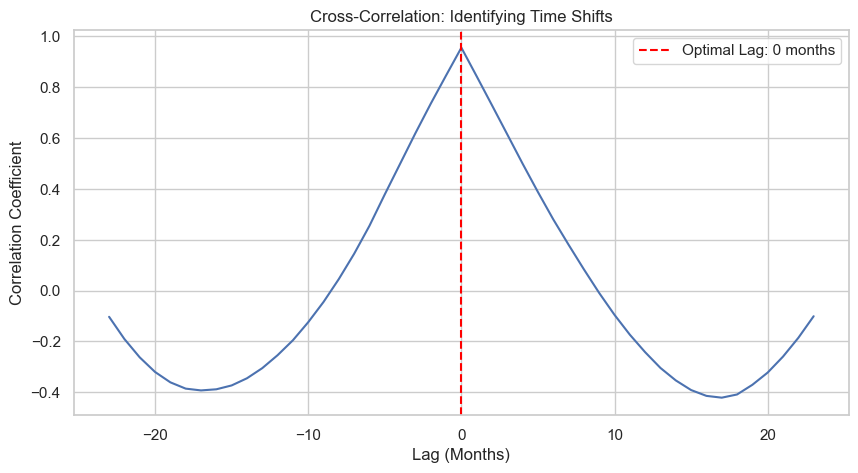

>> Timing is perfect.


In [14]:
from scipy import signal

def find_time_lag(obs, sim):
    # Normalize signals
    obs = (obs - obs.mean()) / (obs.std() * len(obs))
    sim = (sim - sim.mean()) / (sim.std())
    
    correlation = signal.correlate(obs, sim, mode='full')
    lags = signal.correlation_lags(len(obs), len(sim), mode='full')
    
    lag_idx = np.argmax(correlation)
    optimal_lag = lags[lag_idx]
    
    return optimal_lag, lags, correlation

lag, lags, corr = find_time_lag(df['Observed_Pressure'], df['Simulated_Pressure'])

plt.figure(figsize=(10, 5))
plt.plot(lags, corr)
plt.axvline(lag, color='red', linestyle='--', label=f'Optimal Lag: {lag} months')
plt.title('Cross-Correlation: Identifying Time Shifts')
plt.xlabel('Lag (Months)')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()

if lag == 0:
    print(">> Timing is perfect.")
elif lag > 0:
    print(f">> WARNING: Simulation is AHEAD of reality by {lag} months. (Events happen too early in Sim)")
else:
    print(f">> WARNING: Simulation is BEHIND reality by {abs(lag)} months. (Events happen too late in Sim)")

## 13. Interactive Dashboard
Static plots are limited. Here we use **Plotly** to create an interactive chart where you can zoom, hover to see exact values, and toggle curves on/off.

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces for Pressure
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['Observed_Pressure'], name="Obs Pressure", mode='markers', marker=dict(color='blue', size=8)),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['Simulated_Pressure'], name="Sim Pressure", mode='lines', line=dict(color='blue')),
    secondary_y=False,
)

# Add traces for Oil Rate
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['Observed_OilRate'], name="Obs Oil Rate", mode='markers', marker=dict(color='green', symbol='triangle-up', size=8)),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['Simulated_OilRate'], name="Sim Oil Rate", mode='lines', line=dict(color='green', dash='dash')),
    secondary_y=True,
)

# Add Titles and Sliders
fig.update_layout(
    title_text="Interactive History Match Analysis",
    hovermode="x unified"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Pressure (psi)", secondary_y=False)
fig.update_yaxes(title_text="Oil Rate (stb/d)", secondary_y=True)

fig.show()